In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from HelperFunctions import AcceptOrReject

In [11]:
cond_ice = 60.0 # Conductivity of ice
cond_water = 2380.0 # Conductivity sea water


## Define the forward model

In [12]:
def Rv(z):
    return 1.0/np.sqrt(4.0*z*z+1.0)

def Em31Model(ice_thick):
    """ Returns the predicted conductivity returned by the EM31 system given a particular ice thickness. """
    return cond_ice*(1.0-Rv(ice_thick)) + cond_water*Rv(ice_thick)

In [52]:
thicknesses = np.linspace(0.1, 5, 200)

pred_meas = Em31Model(thicknesses)


### Define the Log-Likelihood function

In [53]:
def LogLikelihood(thick, obs_cond):
    """ Returns the log likelihood. 
        
        ARGS:
            thick (float or np.array): Thickness of the ice.
            obs_cond (float): Observed conductivity returned by the EM31.
        
        RETURNS:
            float or np.array: The natural log of the likelihood function up to a constant.
        
    """
    obs_var = 20.0**2
    
    pred_cond = Em31Model(thick)
    diff = obs_cond-pred_cond
    
    return -0.5*diff*diff/obs_var
    
    
def LogPrior(thick):
    """ Returns the log of the prior density (up to a normalizing constant) on the ice thickness.
        
        ARGS:
            thick (float or np.array): Ice thickness
            
        RETURNS:
            float or np.array: The natural log of the prior density.
    """
    
    mu = 1.0
    prior_std = 3.0
    lb =0.01
    ub =6.0
    
    gauss_part = -0.5*((thick-mu)/prior_std)**2
    
    large_val =1e10
    
    
    if(thick is float):
        uni_part = 0.0
        
        if((thick<lb)|(thick>ub)):
            uni_part = -large_val
    else:
        uni_part = np.zeros(thick.shape)
        uni_part[(thick<lb)|(thick>ub)] = -large_val
        
    return gauss_part + uni_part
    
def LogPosterior(thick, obs_cond):
    """ Returns the log posterior (up to a normalizing constant) """
    
    return LogPrior(thick) + LogLikelihood(thick,obs_cond)
    
    

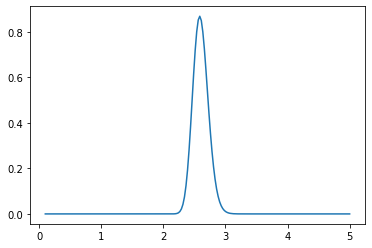

In [58]:
obs_cond = 500

post = np.exp(LogPosterior(thicknesses,obs_cond))
plt.plot(thicknesses,post)

## Metropolis-Hastings MCMC

The Metropolis-Hastings rule is given by


In [70]:
num_steps = 500
prop_std = 0.1

# Intialize empty arrays for the thickness samples the log posterior pdfs at each sample
samps = np.zeros((num_steps))
log_pdfs = np.zeros((num_steps))

samps[0] = 2.0 # set the initial thickness
log_pdfs[0] = LogPosterior(samps[0], obs_cond)

for i in range(num_steps-1):
    
    # Generate a proposed move
    prop = samps[i] + prop_std*np.random.randn()
    
    # Evaluate the log posterior at the proposed point
    prop_log_pdf = LogPosterior(prop, obs_cond)
    
    gamma = np.exp(prop_log_pdf - log_pdfs[i])
    
    # Part of your pset is to figure out what's going on in the AcceptOrReject function
    should_accept = AcceptOrReject(gamma)
    
    if(should_accept):
        samps[i+1] = prop
        log_pdfs[i+1] = prop_log_pdf
    else:
        samps[i+1] = samps[i]
        log_pdfs[i+1]  = log_pdfs[i]
        

### Plot the trace of the MCMC chain

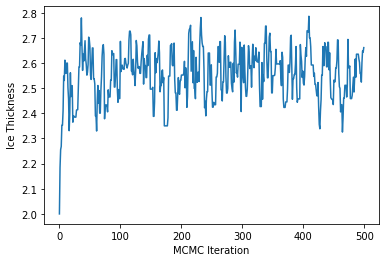

In [71]:
plt.plot(samps)

plt.xlabel('MCMC Iteration')
plt.ylabel('Ice Thickness')
plt.show()

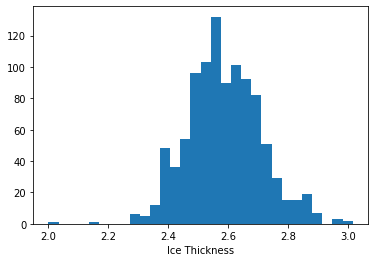

In [68]:
plt.hist(samps,30)

plt.xlabel('Ice Thickness')
plt.show()